In [2]:
pip -q install transformers accelerate sentencepiece pydantic pandas numpy matplotlib

In [4]:
import json, random

def make_one(i):
    age_bins = {"18-24": 0.1+random.random()*0.2, "25-34": 0.2+random.random()*0.3, "35-44": 0.1+random.random()*0.3, "45+": 0.1+random.random()*0.3}
    s = sum(age_bins.values()); age_bins={k:v/s for k,v in age_bins.items()}
    interest = {"sports": random.random(), "health": random.random(), "finance": random.random(), "family": random.random(), "tech": random.random()}
    s = sum(interest.values()); interest={k:v/s for k,v in interest.items()}
    device = {"mobile": random.random(), "ctv": random.random(), "web": random.random()}
    s = sum(device.values()); device={k:v/s for k,v in device.items()}

    return {
        "campaign_id": f"c_{i:03d}",
        "region": random.choice(["NC","NJ","CA","TX"]),
        "time_window": "2026-01-01",
        "population_summary": {
            "age_bins": age_bins,
            "interest_clusters": interest,
            "device_mix": device,
            "avg_freq_7d": round(1.5 + random.random()*6, 2),
            "population_size": random.choice([200, 600, 1200, 5000])  # 用来模拟k匿名阈值
        },
        "constraints": {
            "k_anonymity_min": 500,
            "dp_epsilon": 3.0,
            "sensitive_topics_blocked": ["politics", "medical_condition"]
        }
    }

data = [make_one(i) for i in range(1, 21)]
print("sample record:\n", json.dumps(data[0], indent=2)[:600], "...")


sample record:
 {
  "campaign_id": "c_001",
  "region": "CA",
  "time_window": "2026-01-01",
  "population_summary": {
    "age_bins": {
      "18-24": 0.22869667685631467,
      "25-34": 0.35786201044444055,
      "35-44": 0.16133370414107956,
      "45+": 0.2521076085581652
    },
    "interest_clusters": {
      "sports": 0.29377641837579166,
      "health": 0.08613546014353687,
      "finance": 0.30256469088933124,
      "family": 0.19323992047063188,
      "tech": 0.12428351012070832
    },
    "device_mix": {
      "mobile": 0.26187888087305844,
      "ctv": 0.11955462204516226,
      "web": 0.618566497 ...


In [6]:
def layer1_privacy_abstraction(record):
    pop = record["population_summary"]
    constraints = record["constraints"]
    kmin = constraints["k_anonymity_min"]

    # k-anonymity check (用 population_size 模拟)
    if pop.get("population_size", 0) < kmin:
        return {
            "campaign_id": record["campaign_id"],
            "privacy_status": "REJECT",
            "reason": f"population_size<{kmin}",
            "safe_population_features": None
        }

    # “粗化”年龄段：18-34 vs 35+（示例）
    age = pop["age_bins"]
    age_coarse = {
        "18-34": round(age.get("18-24",0)+age.get("25-34",0), 4),
        "35+": round(age.get("35-44",0)+age.get("45+",0), 4),
    }

    safe = {
        "age_bins": age_coarse,
        "interest_clusters": pop["interest_clusters"],
        "device_mix": pop["device_mix"],
        "avg_freq_7d": pop["avg_freq_7d"],
    }

    return {
        "campaign_id": record["campaign_id"],
        "privacy_status": "PASS",
        "safe_population_features": safe
    }

l1 = [layer1_privacy_abstraction(r) for r in data]
sum_pass = sum(1 for x in l1 if x["privacy_status"]=="PASS")
print("PASS:", sum_pass, "REJECT:", len(l1)-sum_pass)
print("example PASS:\n", [x for x in l1 if x["privacy_status"]=="PASS"][0])


PASS: 17 REJECT: 3
example PASS:
 {'campaign_id': 'c_001', 'privacy_status': 'PASS', 'safe_population_features': {'age_bins': {'18-34': 0.5866, '35+': 0.4134}, 'interest_clusters': {'sports': 0.29377641837579166, 'health': 0.08613546014353687, 'finance': 0.30256469088933124, 'family': 0.19323992047063188, 'tech': 0.12428351012070832}, 'device_mix': {'mobile': 0.26187888087305844, 'ctv': 0.11955462204516226, 'web': 0.6185664970817792}, 'avg_freq_7d': 2.93}}


In [14]:
from transformers import pipeline

gen = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=128)

import re

def layer2_llm_advisor_real(l1_out):
    if l1_out["privacy_status"] != "PASS":
        return {"campaign_id": l1_out["campaign_id"], "llm_decision": None, "status": "SKIP_PRIVACY_REJECT"}

    f = l1_out["safe_population_features"]
    prompt = f"""
You are an AI decision advisor. You must choose one strategy from:
[CTV_family_tech, Mobile_sports, Web_finance, Mobile_generic]

Input (privacy-preserving population features):
age_bins={f['age_bins']}
interest_clusters={f['interest_clusters']}
device_mix={f['device_mix']}
avg_freq_7d={f['avg_freq_7d']}

Output strictly in JSON with keys: strategy, confidence (0-1), rationale (list of strings), risk_notes (list of strings).
"""
    out = gen(prompt)[0]["generated_text"]

    # 简易容错解析：从输出里截取 JSON
    m = re.search(r"\{.*\}", out, re.S)
    if not m:
        return {"campaign_id": l1_out["campaign_id"], "llm_decision": None, "status": "PARSE_FAIL"}

    try:
        obj = json.loads(m.group(0))
        # 清洗字段
        obj["confidence"] = float(obj.get("confidence", 0.5))
        if "rationale" not in obj: obj["rationale"] = [str(obj)]
        if "risk_notes" not in obj: obj["risk_notes"] = []
        return {"campaign_id": l1_out["campaign_id"], "llm_decision": obj, "status":"OK"}
    except Exception:
        return {"campaign_id": l1_out["campaign_id"], "llm_decision": None, "status":"JSON_FAIL"}

# 用真实LLM替换
l2_real = [layer2_llm_advisor_real(x) for x in l1]
l3_real = [layer3_policy_validate(a,b) for a,b in zip(l1,l2_real)]
print("example real LLM:\n", [x for x in l2_real if x["status"]=="OK"][0])


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


IndexError: list index out of range

In [8]:
POLICY = {
    "max_frequency_cap": 6,
    "blocked_topics": ["politics", "medical_condition"],
    "min_confidence": 0.60,
    "allowed_strategies": ["CTV_family_tech","Mobile_sports","Web_finance","Mobile_generic"],
    "fallback_strategy": "Mobile_generic"
}

def layer3_policy_validate(l1_out, l2_out, policy=POLICY):
    cid = l1_out["campaign_id"]
    if l1_out["privacy_status"] != "PASS":
        return {"campaign_id": cid, "final_decision": {"strategy": None, "status":"REJECT_PRIVACY", "policy_checks":["privacy_reject"]}}

    if l2_out["status"] != "OK" or not l2_out["llm_decision"]:
        return {"campaign_id": cid, "final_decision": {"strategy": policy["fallback_strategy"], "status":"FALLBACK", "policy_checks":["llm_missing"]}}

    d = l2_out["llm_decision"]
    checks = []

    # allowed strategy
    if d["strategy"] not in policy["allowed_strategies"]:
        checks.append("strategy_not_allowed")
        return {"campaign_id": cid, "final_decision": {"strategy": policy["fallback_strategy"], "status":"FALLBACK", "policy_checks":checks}}

    # confidence
    if d["confidence"] < policy["min_confidence"]:
        checks.append("confidence_low")
        return {"campaign_id": cid, "final_decision": {"strategy": policy["fallback_strategy"], "status":"FALLBACK", "policy_checks":checks}}

    checks += ["allowed_strategy","confidence_ok"]
    return {"campaign_id": cid, "final_decision": {"strategy": d["strategy"], "status":"APPROVED", "policy_checks":checks}}

l3 = [layer3_policy_validate(a,b) for a,b in zip(l1,l2)]
print("example L3:\n", [x for x in l3 if x["final_decision"]["status"]!="REJECT_PRIVACY"][0])


example L3:
 {'campaign_id': 'c_001', 'final_decision': {'strategy': 'Web_finance', 'status': 'APPROVED', 'policy_checks': ['allowed_strategy', 'confidence_ok']}}


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def decision_for_one(record):
    a = layer1_privacy_abstraction(record)
    b = layer2_llm_advisor(a)
    c = layer3_policy_validate(a,b)
    return a,b,c

def stability_test(record, n=15, noise=0.02):
    # 对 interest/device 做轻微扰动，观察最终策略是否变化
    base_a, base_b, base_c = decision_for_one(record)
    if base_a["privacy_status"] != "PASS":
        return None

    base_strategy = base_c["final_decision"]["strategy"]
    changes = 0

    for _ in range(n):
        r2 = json.loads(json.dumps(record))
        # 扰动 interest
        ic = r2["population_summary"]["interest_clusters"]
        for k in ic:
            ic[k] = max(0.0, ic[k] + np.random.uniform(-noise, noise))
        s = sum(ic.values());
        for k in ic: ic[k] /= s

        # 扰动 device
        dm = r2["population_summary"]["device_mix"]
        for k in dm:
            dm[k] = max(0.0, dm[k] + np.random.uniform(-noise, noise))
        s = sum(dm.values());
        for k in dm: dm[k] /= s

        _, _, c = decision_for_one(r2)
        if c["final_decision"]["strategy"] != base_strategy:
            changes += 1

    return changes / n

rows = []
for r in data:
    a,b,c = decision_for_one(r)
    rows.append({
        "campaign_id": r["campaign_id"],
        "privacy_status": a["privacy_status"],
        "final_status": c["final_decision"]["status"],
        "strategy": c["final_decision"]["strategy"],
        "stability_change_rate": stability_test(r) if a["privacy_status"]=="PASS" else None
    })

df = pd.DataFrame(rows)
df


,campaign_id,privacy_status,final_status,strategy,stability_change_rate
0,c_001,PASS,APPROVED,Web_finance,0.266667
1,c_002,PASS,APPROVED,Mobile_generic,0.000000
2,c_003,PASS,APPROVED,Mobile_generic,0.133333
3,c_004,PASS,APPROVED,Mobile_generic,0.000000
4,c_005,PASS,APPROVED,Web_finance,0.133333
5,c_006,PASS,APPROVED,Mobile_generic,0.000000
6,c_007,PASS,APPROVED,CTV_family_tech,0.000000
7,c_008,PASS,APPROVED,Mobile_sports,0.400000
8,c_009,PASS,APPROVED,Mobile_generic,0.000000
9,c_010,PASS,APPROVED,Mobile_generic,0.000000


Fallback rate (policy/low confidence): 0.0
Privacy reject rate: 0.15
Avg stability change rate: 0.055


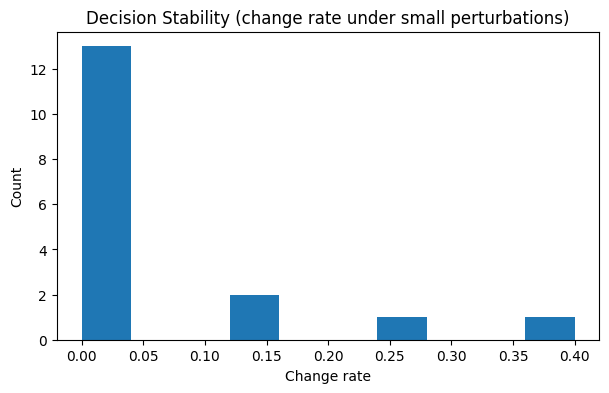

In [10]:
pass_df = df[df["privacy_status"]=="PASS"].dropna(subset=["stability_change_rate"])
violation_rate = (df["final_status"]=="FALLBACK").mean()
privacy_reject_rate = (df["privacy_status"]=="REJECT").mean()

print("Fallback rate (policy/low confidence):", round(violation_rate,3))
print("Privacy reject rate:", round(privacy_reject_rate,3))
print("Avg stability change rate:", round(pass_df["stability_change_rate"].mean(),3))

plt.figure(figsize=(7,4))
plt.hist(pass_df["stability_change_rate"], bins=10)
plt.title("Decision Stability (change rate under small perturbations)")
plt.xlabel("Change rate")
plt.ylabel("Count")
plt.show()


In [15]:
df.to_csv("padlds_metrics.csv", index=False)
print("saved padlds_metrics.csv")


saved padlds_metrics.csv
